Import Modules

In [ ]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, ViTModel, ViTFeatureExtractor, AdamW
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T
import seaborn as sns
!pip install rouge-score
!pip install bert-score
from torch.utils.data import DataLoader
import pandas as pd
from transformers import BartTokenizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
from torch.utils.data import DataLoader
from transformers import BartTokenizer

## Model Weights
Link: https://drive.google.com/file/d/1CO6yqIIQ_goKJjWL7GSRLR8j09CWNLcH/view

Setting Up the Logger

In [ ]:
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)


Sarcasm Dataset CLASS!

In [ ]:
class SarcasmDataset(Dataset):
    def __init__(self, tsv_file, image_dir, d_pkl, o_pkl, tokenizer, max_length=256):
        logger.debug(f"Loading TSV file from {tsv_file}")
        self.df = pd.read_csv(tsv_file, sep='\t')
        self.image_dir = image_dir
        logger.debug(f"Loading image descriptions from {d_pkl}")
        import pickle
        with open(d_pkl, 'rb') as f:
            self.img_descriptions = pickle.load(f)
        logger.debug(f"Loading object tokens from {o_pkl}")
        with open(o_pkl, 'rb') as f:
            self.obj_tokens = pickle.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.augment_transforms = T.Compose([
            T.RandomResizedCrop(224),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = str(row['pid'])
        caption = row['text']
        explanation = row.get('explanation', "")
        target = row.get('sarcasm_target', "")
        
        img_desc = self.img_descriptions.get(pid, "")
        obj_tokens = self.obj_tokens.get(pid, "")
        
        concat_text = caption + " " + str(img_desc) + " " + str(obj_tokens) + " </s> " + target
        source = self.tokenizer(concat_text, truncation=True, padding='max_length',
                                  max_length=self.max_length, return_tensors="pt")
        target_encoding = None
        if explanation:
            target_encoding = self.tokenizer(explanation, truncation=True, padding='max_length',
                                             max_length=self.max_length, return_tensors="pt")
        
        from PIL import Image
        img_path = os.path.join(self.image_dir, f"{pid}.jpg")
        image = Image.open(img_path).convert("RGB")
        image = self.augment_transforms(image)
        
        sample = {
            "pid": pid,
            "input_ids": source.input_ids.squeeze(0),
            "attention_mask": source.attention_mask.squeeze(0),
            "image": image,
        }
        if target_encoding is not None:
            sample["decoder_input_ids"] = target_encoding.input_ids.squeeze(0)
            sample["decoder_attention_mask"] = target_encoding.attention_mask.squeeze(0)
            sample["labels"] = target_encoding.input_ids.squeeze(0)
        logger.debug(f"Loaded sample pid={pid}")
        return sample

Fusion Class

In [ ]:
class ConcatFusion(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.3):
        super(ConcatFusion, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        logger.debug("Initialized ConcatFusion module")

    def forward(self, text_features, vis_features):
        """
        text_features: Tensor of shape [B, seq_len, hidden_dim]
        vis_features: Tensor of shape [B, seq_len, hidden_dim]
        """
        fused = torch.cat([text_features, vis_features], dim=-1)  # [B, seq_len, 2*hidden_dim]!!!!!!!
        output = self.fc(fused)  # [B, seq_len, hidden_dim]!!!!!
        logger.debug("ConcatFusion forward pass complete")
        return output


TURO MODEL class!!!

In [ ]:
class TurboModelNewFusion(nn.Module):
    def __init__(self, bart_model_name="facebook/bart-base", vit_model_name="google/vit-base-patch16-224-in21k", hidden_dim=768, dropout_prob=0.3):
        super(TurboModelNewFusion, self).__init__()
        logger.debug("Loading BART model and tokenizer")
        self.bart = BartForConditionalGeneration.from_pretrained(bart_model_name)
        self.tokenizer = BartTokenizer.from_pretrained(bart_model_name)

        logger.debug("Loading ViT model and feature extractor")
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

        self.visual_proj = nn.Linear(self.vit.config.hidden_size, hidden_dim)
        self.text_self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.vis_self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)

        self.concat_fusion = ConcatFusion(hidden_dim, dropout_prob=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        logger.debug("TurboModelNewFusion initialization complete")

    def forward(self, input_ids, attention_mask, images, decoder_input_ids=None, decoder_attention_mask=None):
        encoder_outputs = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        E_text = encoder_outputs.last_hidden_state  # [B, seq_len, hidden_dim]!!!!!!!!
        logger.debug("Encoded text with BART encoder")

        # ViT part.
        image_inputs = self.feature_extractor(images=images, return_tensors="pt")
        image_inputs = {k: v.to(input_ids.device) for k, v in image_inputs.items()}
        vit_outputs = self.vit(**image_inputs)
        E_vis = vit_outputs.last_hidden_state  # [B, num_patches, H_vit] !
        E_vis = self.visual_proj(E_vis)         # [B, num_patches, hiden_im] ╰(*°▽°*)╯
        logger.debug("Extracted and projected visual features")

        # self-attention .!_!.
        A_t, _ = self.text_self_attn(query=E_text, key=E_text, value=E_text)
        A_v, _ = self.vis_self_attn(query=E_vis, key=E_vis, value=E_vis)
        logger.debug("Computed self-attention for text and visual features")

        E_vis_avg = A_v.mean(dim=1, keepdim=True)   
        E_vis_exp = E_vis_avg.expand(-1, E_text.size(1), -1)  

        fused_features = self.concat_fusion(A_t, E_vis_exp)
        Z = fused_features + E_text
        Z = self.dropout(Z)
        logger.debug("Combined fused features with text encoder output")

        if decoder_input_ids is not None and decoder_attention_mask is not None:
            decoder_outputs = self.bart.model.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=Z,
                encoder_attention_mask=attention_mask,
            )
            logits = self.bart.lm_head(decoder_outputs.last_hidden_state)
            return logits
        else:
            encoder_outputs_custom = type('', (), {})()
            encoder_outputs_custom.last_hidden_state = Z
            generated_ids = self.bart.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_outputs=encoder_outputs_custom,
                max_length=128,
                num_beams=5,
                early_stopping=True
            )
            logger.debug("Generation complete in inference mode")
            return generated_ids

TRAIN AND EVAL METHODS!

In [ ]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    logger.info("Starting training epoch")
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        decoder_input_ids = batch["decoder_input_ids"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)
        labels = batch["labels"].to(device)
        images = batch["image"]

        logits = model(input_ids, attention_mask, images, decoder_input_ids, decoder_attention_mask)
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                               shift_labels.view(-1),
                               ignore_index=model.tokenizer.pad_token_id)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        logger.debug(f"Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
        print(f"Epoch Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(dataloader)
    logger.info(f"Epoch training complete - Average Loss: {avg_loss:.4f}")
    print(f"Epoch training complete - Average Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    logger.info("Starting evaluation")
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            decoder_input_ids = batch["decoder_input_ids"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)
            labels = batch["labels"].to(device)
            images = batch["image"]

            logits = model(input_ids, attention_mask, images, decoder_input_ids, decoder_attention_mask)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                                   shift_labels.view(-1),
                                   ignore_index=model.tokenizer.pad_token_id)
            total_loss += loss.item()
            logger.debug(f"Eval Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
            print(f"Eval Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(dataloader)
    logger.info(f"Evaluation complete - Average Loss: {avg_loss:.4f}")
    print(f"Evaluation complete - Average Loss: {avg_loss:.4f}")
    return avg_loss

Method Callings for Training! Had called and run this in another file, see that for the incode prints...

In [ ]:
train_tsv = r"/kaggle/input/nlpassign3t3/train_df.tsv"
val_tsv = r"/kaggle/input/nlpassign3t3/val_df.tsv"
image_dir = r"/kaggle/input/imagesnlpt3/images"
d_pkl = r"/kaggle/input/nlpassign3t3/D_train.pkl"
o_pkl = r"/kaggle/input/nlpassign3t3/O_train.pkl"

max_length = 256
batch_size = 8
num_epochs = 20
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
print(f"Using device: {device}")

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

train_dataset = SarcasmDataset(train_tsv, image_dir, d_pkl, o_pkl, tokenizer, max_length)
val_dataset   = SarcasmDataset(val_tsv, image_dir, d_pkl, o_pkl, tokenizer, max_length)

def collate_fn(batch):
    collated = {
        "pid": [item["pid"] for item in batch],
        "image": [item["image"] for item in batch]
    }
    for key in ["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"]:
        if key in batch[0]:
            collated[key] = torch.stack([item[key] for item in batch])
    return collated

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = TurboModelNewFusion(dropout_prob=0.5).to(device)
for param in model.vit.parameters():
    param.requires_grad = False
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

logger.info("Starting training process")
print("Starting training process")

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} started")
    logger.info(f"Epoch {epoch+1}/{num_epochs} started")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = evaluate(model, val_loader, device)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    logger.info(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)
    checkpoint_path = f"model_checkpoint_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    logger.info(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")
    print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_list, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
loss_plot_path = "loss_plot.png"
plt.savefig(loss_plot_path)
plt.close()
logger.info(f"Saved loss plot to {loss_plot_path}")
print(f"Saved loss plot to {loss_plot_path}")
final_checkpoint = f"model_checkpoint_epoch{num_epochs}.pth"
model.load_state_dict(torch.load(final_checkpoint, map_location=device))
logger.info(f"Loaded final checkpoint: {final_checkpoint}")
print(f"Loaded final checkpoint: {final_checkpoint}")

test_model(model, val_loader, device, output_file="test_explanations.tsv")

Used agaion by testing and loss, evals

In [10]:
class SharedFusion(nn.Module):
    def __init__(self, hidden_dim):
        super(SharedFusion, self).__init__()
        self.W_v = nn.Linear(hidden_dim, hidden_dim)
        self.W_t = nn.Linear(hidden_dim, hidden_dim)
        self.b_v = nn.Parameter(torch.zeros(hidden_dim))
        self.b_t = nn.Parameter(torch.zeros(hidden_dim))
        self.alpha1 = nn.Parameter(torch.tensor(1.0))
        self.alpha2 = nn.Parameter(torch.tensor(1.0))
        self.beta1  = nn.Parameter(torch.tensor(1.0))
        self.beta2  = nn.Parameter(torch.tensor(1.0))
        logger.debug("Initialized SharedFusion module")

    def forward(self, E_v, E_t, A_v, A_t):
        F_tv = A_t * E_v     # Text-guided visual fusion!
        F_vt = A_v * E_t     # Visual-guided text fusion!

        G_v = torch.sigmoid(self.W_v(E_v) + self.b_v)
        G_t = torch.sigmoid(self.W_t(E_t) + self.b_t)

        F_v = G_v * E_v + (1 - G_v) * F_tv
        F_t = G_t * E_t + (1 - G_t) * F_vt

        F1 = F_vt
        F2 = F_tv

        F_SF = self.alpha1 * F1 + self.alpha2 * F2 + self.beta1 * F_v + self.beta2 * F_t
        logger.debug("SharedFusion forward pass complete")
        return F_SF


class SarcasmDataset(Dataset):
    def __init__(self, tsv_file, image_dir, d_pkl, o_pkl, tokenizer, max_length=256):
        logger.debug(f"Loading TSV file from {tsv_file}")
        self.df = pd.read_csv(tsv_file, sep='\t')
        self.image_dir = image_dir
        logger.debug(f"Loading image descriptions from {d_pkl}")
        with open(d_pkl, 'rb') as f:
            import pickle
            self.img_descriptions = pickle.load(f)
        logger.debug(f"Loading object tokens from {o_pkl}")
        with open(o_pkl, 'rb') as f:
            self.obj_tokens = pickle.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = str(row['pid'])
        caption = row['text']
        explanation = row.get('explanation', "")
        target = row.get('sarcasm_target', "")

        img_desc = self.img_descriptions.get(pid, "")
        obj_tokens = self.obj_tokens.get(pid, "")

        concat_text = caption + " " + str(img_desc) + " " + str(obj_tokens) + " </s> " + target
        source = self.tokenizer(concat_text, truncation=True, padding='max_length',
                                max_length=self.max_length, return_tensors="pt")
        target_encoding = None
        if explanation:
            target_encoding = self.tokenizer(explanation, truncation=True, padding='max_length',
                                             max_length=self.max_length, return_tensors="pt")

        from PIL import Image
        img_path = os.path.join(self.image_dir, f"{pid}.jpg")
        image = Image.open(img_path).convert("RGB")

        sample = {
            "pid": pid,
            "input_ids": source.input_ids.squeeze(0),
            "attention_mask": source.attention_mask.squeeze(0),
            "image": image,
        }
        if target_encoding is not None:
            sample["decoder_input_ids"] = target_encoding.input_ids.squeeze(0)
            sample["decoder_attention_mask"] = target_encoding.attention_mask.squeeze(0)
            sample["labels"] = target_encoding.input_ids.squeeze(0)
        logger.debug(f"Loaded sample pid={pid}")
        return sample

from transformers.modeling_outputs import BaseModelOutput

class TurboModel(nn.Module):
    def __init__(
        self,
        bart_model_name: str = "facebook/bart-base",
        vit_model_name: str = "google/vit-base-patch16-224-in21k",
        hidden_dim: int = 768
    ):
        super(TurboModel, self).__init__()
        logger.debug("Loading BART model and tokenizer")
        self.bart = BartForConditionalGeneration.from_pretrained(bart_model_name)
        self.tokenizer = BartTokenizer.from_pretrained(bart_model_name)

        logger.debug("Loading ViT model and feature extractor")
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

        self.visual_proj = nn.Linear(self.vit.config.hidden_size, hidden_dim)
        self.text_self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.vis_self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)

        self.shared_fusion = SharedFusion(hidden_dim)
        logger.debug("TurboModel initialization complete")

    def forward(
        self,
        input_ids,
        attention_mask,
        images,
        decoder_input_ids=None,
        decoder_attention_mask=None
    ):
        # Tex-Encode
        encoder_outputs = self.bart.model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        E_text = encoder_outputs.last_hidden_state 
        logger.debug("Encoded text with BART encoder")

        # Viz Features extract and proj!
        image_inputs = self.feature_extractor(images=images, return_tensors="pt")
        image_inputs = {k: v.to(input_ids.device) for k, v in image_inputs.items()}
        vit_outputs = self.vit(**image_inputs)
        E_vis = self.visual_proj(vit_outputs.last_hidden_state) 
        logger.debug("Extracted and projected visual features")

        # St-Attn on each mod
        A_t, _ = self.text_self_attn(E_text, E_text, E_text)
        A_v, _ = self.vis_self_attn(E_vis, E_vis, E_vis)
        logger.debug("Computed self-attention for text and visual features")

        # Viz stat and txt L expnasion
        E_vis_avg = E_vis.mean(dim=1, keepdim=True)
        A_v_avg   = A_v.mean(dim=1, keepdim=True)
        E_vis_exp = E_vis_avg.expand(-1, E_text.size(1), -1)
        A_v_exp   = A_v_avg.expand(-1, E_text.size(1), -1)
        logger.debug("Averaged and expanded visual features to match text sequence length")

        #  The best GOAT PART- FUSIONNNNN!!!
        fusion_out = self.shared_fusion(E_vis_exp, E_text, A_v_exp, A_t)
        Z = fusion_out + E_text
        logger.debug("Combined fusion output with text encoder output")

        if decoder_input_ids is not None and decoder_attention_mask is not None:
            dec_outs = self.bart.model.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=Z,
                encoder_attention_mask=attention_mask,
            )
            logits = self.bart.lm_head(dec_outs.last_hidden_state)
            return logits

        encoder_outputs_custom = BaseModelOutput(last_hidden_state=Z)
        generated_ids = self.bart.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_outputs=encoder_outputs_custom,
            max_length=128,
            num_beams=5,
            early_stopping=True
        )
        logger.debug("Generation complete in inference mode")
        return generated_ids


def collate_fn(batch):
    collated = {
        "pid": [item["pid"] for item in batch],
        "image": [item["image"] for item in batch]
    }
    for key in ["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"]:
        if key in batch[0]:
            collated[key] = torch.stack([item[key] for item in batch])
    return collated

def evaluate_loss(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            input_ids  = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            decoder_input_ids = batch["decoder_input_ids"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)
            labels = batch["labels"].to(device)
            images = batch["image"]

            logits = model(input_ids, attention_mask, images,
                           decoder_input_ids, decoder_attention_mask)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=model.tokenizer.pad_token_id,
                reduction='mean'
            )
            total_loss += loss.item()
    return total_loss / len(dataloader)
# IMplementing a SImple METEOR as the nltk one was not working due to some wordnet dependency issue...＜（＾－＾）＞!!!!
def simple_meteor(ref: str, hyp: str) -> float:
    """
    - unigram matches
    - precision p = |matches|/|hyp|
    - recall    r = |matches|/|ref|
    - fmean = (10 * p * r) / (r + 9p)
    """
    ref_tokens = ref.split()
    hyp_tokens = hyp.split()
    if not ref_tokens or not hyp_tokens:
        return 0.0
    matches = sum(1 for w in hyp_tokens if w in ref_tokens)
    p = matches / len(hyp_tokens)
    r = matches / len(ref_tokens)
    if p + r == 0:
        return 0.0
    return (10 * p * r) / (r + 9 * p)

def evaluate_metrics(model, dataloader, device):
    model.eval()
    candidates, references = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"]

            gen_ids = model(input_ids, attention_mask, images)
            gen_texts = model.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
            candidates.extend(gen_texts)

            if "labels" in batch:
                ref_texts = model.tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
                references.extend(ref_texts)

    n = len(candidates)
    smoothie = SmoothingFunction().method4

    # ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    r1 = r2 = rL = 0.0
    for ref, cand in zip(references, candidates):
        sc = rouge.score(ref, cand)
        r1 += sc['rouge1'].fmeasure
        r2 += sc['rouge2'].fmeasure
        rL += sc['rougeL'].fmeasure
    r1, r2, rL = r1/n, r2/n, rL/n

    # BLEU‑1…4
    weights = [(1,0,0,0), (0.5,0.5,0,0), (0.33,0.33,0.33,0), (0.25,0.25,0.25,0.25)]
    bleus = []
    for w in weights:
        bleus.append(
            sum(sentence_bleu([ref.split()], cand.split(), weights=w, smoothing_function=smoothie)
                for ref, cand in zip(references, candidates)) / n
        )
    bleu1, bleu2, bleu3, bleu4 = bleus

    # METEOR- SIMPLE!!
    meteor = sum(simple_meteor(r, c) for r, c in zip(references, candidates)) / n

    # BERTScore
    P, R, F1 = bert_score(candidates, references, lang="en", verbose=False)
    bertsc = F1.mean().item()

    return {
        'rouge1': r1, 'rouge2': r2, 'rougeL': rL,
        'bleu1': bleu1, 'bleu2': bleu2, 'bleu3': bleu3, 'bleu4': bleu4,
        'meteor': meteor, 'bertscore': bertsc
    }

if __name__ == "__main__":
    train_tsv      = "/kaggle/input/nlpassign3t3/train_df.tsv"
    val_tsv        = "/kaggle/input/nlpassign3t3/val_df.tsv"
    image_dir      = "/kaggle/input/imagesnlpt3/images"
    d_pkl          = "/kaggle/input/nlpassign3t3/D_train.pkl"
    o_pkl          = "/kaggle/input/nlpassign3t3/O_train.pkl"
    checkpoint_dir = "/kaggle/input/nlpt3/transformers/default/1"
    num_epochs     = 20
    batch_size     = 8

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    train_ds = SarcasmDataset(train_tsv, image_dir, d_pkl, o_pkl, tokenizer)
    val_ds   = SarcasmDataset(val_tsv,   image_dir, d_pkl, o_pkl, tokenizer)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model = TurboModel().to(device)
    model.tokenizer = tokenizer

    records = []
    for epoch in range(1, num_epochs+1):
        ckpt = os.path.join(checkpoint_dir, f"model_checkpoint_epoch{epoch}.pth")
        print(f"\n--- Epoch {epoch} --- loading {ckpt}")
        state = torch.load(ckpt, map_location=device)
        model.load_state_dict(state)

        tr_loss = evaluate_loss(model, train_loader, device)
        val_met = evaluate_metrics(model, val_loader, device)

        print(f"Epoch {epoch} ▶ Train Loss: {tr_loss:.4f}  |  "
              f"ROUGE-1: {val_met['rouge1']:.4f}, BLEU-1: {val_met['bleu1']:.4f}, "
              f"METEOR: {val_met['meteor']:.4f}, BERTScore: {val_met['bertscore']:.4f}")

        rec = {'epoch': epoch, 'train_loss': tr_loss}
        rec.update(val_met)
        records.append(rec)

    df = pd.DataFrame(records)
    df.to_csv("checkpoint_eval_results.csv", index=False)
    print("\nSaved all results to checkpoint_eval_results.csv")

Using device: cuda


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



--- Epoch 1 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch1.pth


<ipython-input-10-98fbad0c730c>:368: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 ▶ Train Loss: 1.5660  |  ROUGE-1: 0.4934, BLEU-1: 0.3349, METEOR: 0.3972, BERTScore: 0.9085

--- Epoch 2 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch2.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 2 ▶ Train Loss: 1.0850  |  ROUGE-1: 0.5112, BLEU-1: 0.3597, METEOR: 0.4234, BERTScore: 0.9108

--- Epoch 3 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch3.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3 ▶ Train Loss: 0.7805  |  ROUGE-1: 0.5142, BLEU-1: 0.3506, METEOR: 0.4000, BERTScore: 0.9106

--- Epoch 4 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch4.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4 ▶ Train Loss: 0.5417  |  ROUGE-1: 0.4929, BLEU-1: 0.3421, METEOR: 0.4018, BERTScore: 0.9052

--- Epoch 5 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch5.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5 ▶ Train Loss: 0.3482  |  ROUGE-1: 0.5128, BLEU-1: 0.3628, METEOR: 0.4163, BERTScore: 0.9107

--- Epoch 6 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch6.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 6 ▶ Train Loss: 0.2238  |  ROUGE-1: 0.4828, BLEU-1: 0.3382, METEOR: 0.4040, BERTScore: 0.9047

--- Epoch 7 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch7.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 7 ▶ Train Loss: 0.1374  |  ROUGE-1: 0.4700, BLEU-1: 0.3162, METEOR: 0.3797, BERTScore: 0.9027

--- Epoch 8 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch8.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 8 ▶ Train Loss: 0.1011  |  ROUGE-1: 0.4817, BLEU-1: 0.3307, METEOR: 0.3889, BERTScore: 0.9055

--- Epoch 9 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch9.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 9 ▶ Train Loss: 0.0810  |  ROUGE-1: 0.4901, BLEU-1: 0.3404, METEOR: 0.3989, BERTScore: 0.9051

--- Epoch 10 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch10.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 10 ▶ Train Loss: 0.0565  |  ROUGE-1: 0.4823, BLEU-1: 0.3445, METEOR: 0.4123, BERTScore: 0.9062

--- Epoch 11 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch11.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 11 ▶ Train Loss: 0.0480  |  ROUGE-1: 0.5044, BLEU-1: 0.3572, METEOR: 0.4130, BERTScore: 0.9093

--- Epoch 12 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch12.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 12 ▶ Train Loss: 0.0491  |  ROUGE-1: 0.4791, BLEU-1: 0.3261, METEOR: 0.3870, BERTScore: 0.9023

--- Epoch 13 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch13.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 13 ▶ Train Loss: 0.0425  |  ROUGE-1: 0.4909, BLEU-1: 0.3527, METEOR: 0.4074, BERTScore: 0.9045

--- Epoch 14 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch14.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 14 ▶ Train Loss: 0.0420  |  ROUGE-1: 0.4845, BLEU-1: 0.3483, METEOR: 0.4235, BERTScore: 0.9052

--- Epoch 15 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch15.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 15 ▶ Train Loss: 0.0329  |  ROUGE-1: 0.4837, BLEU-1: 0.3417, METEOR: 0.4038, BERTScore: 0.9071

--- Epoch 16 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch16.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 16 ▶ Train Loss: 0.0346  |  ROUGE-1: 0.4623, BLEU-1: 0.3251, METEOR: 0.3811, BERTScore: 0.9031

--- Epoch 17 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch17.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 17 ▶ Train Loss: 0.0352  |  ROUGE-1: 0.4716, BLEU-1: 0.3327, METEOR: 0.4014, BERTScore: 0.9004

--- Epoch 18 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch18.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 18 ▶ Train Loss: 0.0316  |  ROUGE-1: 0.4456, BLEU-1: 0.3064, METEOR: 0.3615, BERTScore: 0.9006

--- Epoch 19 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch19.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 19 ▶ Train Loss: 0.0325  |  ROUGE-1: 0.4771, BLEU-1: 0.3417, METEOR: 0.3993, BERTScore: 0.9047

--- Epoch 20 --- loading /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch20.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 20 ▶ Train Loss: 0.0237  |  ROUGE-1: 0.4514, BLEU-1: 0.3196, METEOR: 0.3680, BERTScore: 0.9018

Saved all results to checkpoint_eval_results.csv


Testing!

Method to Eval on the test data!

In [ ]:
def test_model(model, dataloader, device, print_examples=False, num_examples=5):
    model.eval()
    all_pids, candidates, references = [], [], []
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"]
            pids = batch.get("pid", [None] * len(images))

            generated_ids = model(input_ids, attention_mask, images)
            gen_texts = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            all_pids.extend(pids)
            candidates.extend(gen_texts)

            if "labels" in batch:
                ref_texts = model.tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
                references.extend(ref_texts)

            print(f"Processed test batch {batch_idx+1}/{len(dataloader)}")
    if print_examples:
        print("\nSample Generated Explanations:\n")
        for i in range(min(num_examples, len(candidates))):
            pid = all_pids[i]
            print(f"PID: {pid}")
            print(f"Generated: {candidates[i]}")
            if references:
                print(f"Reference: {references[i]}")
            print()

PLotting! and few examples!

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


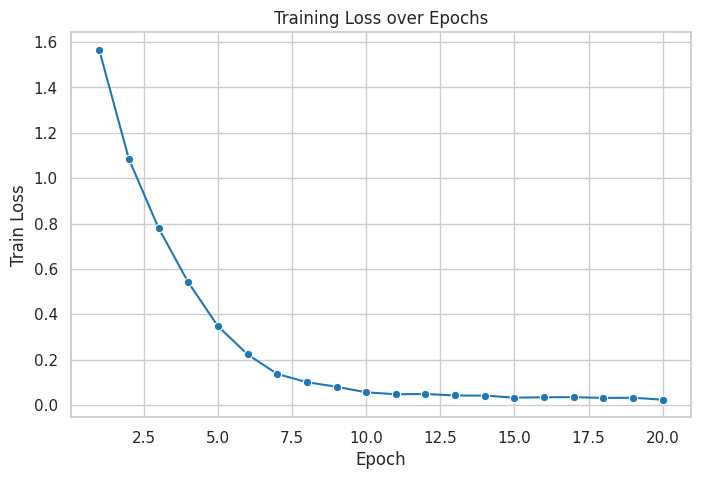

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

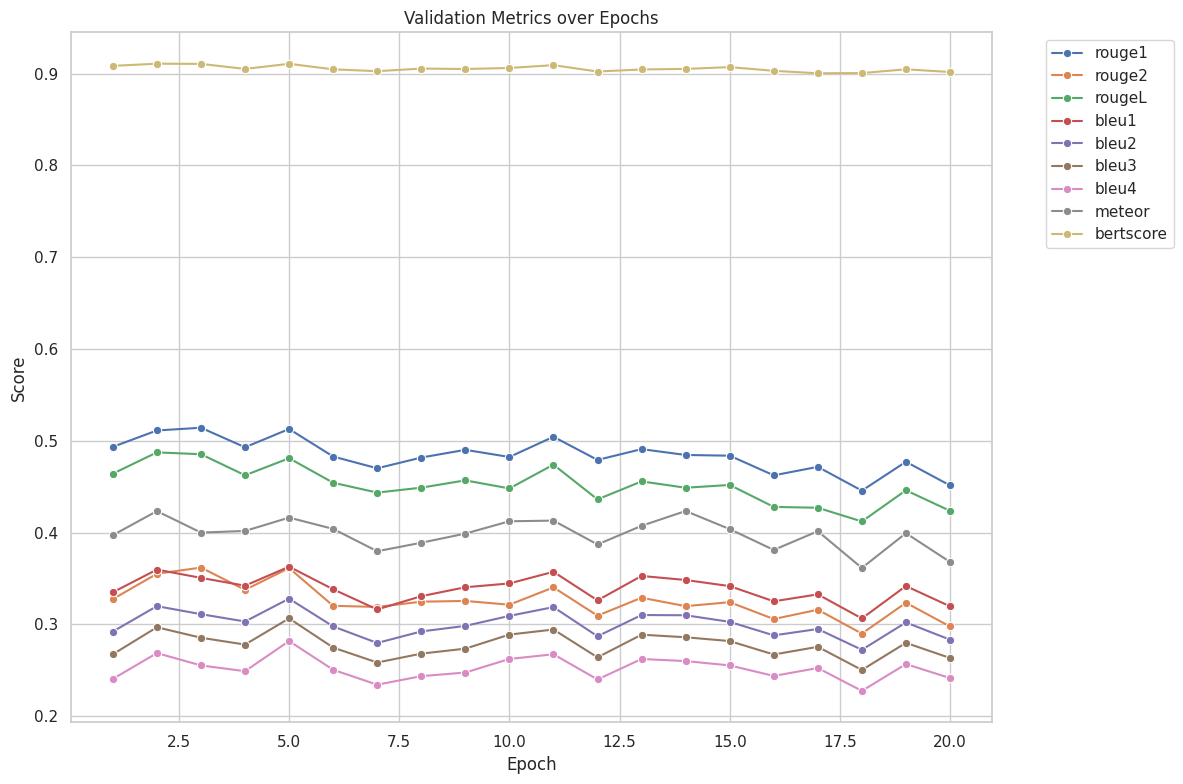

Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Loading checkpoint: /kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch11.pth


<ipython-input-22-62096f38a898>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


Processed test batch 1/22
Processed test batch 2/22
Processed test batch 3/22
Processed test batch 4/22
Processed test batch 5/22
Processed test batch 6/22
Processed test batch 7/22
Processed test batch 8/22
Processed test batch 9/22
Processed test batch 10/22
Processed test batch 11/22
Processed test batch 12/22
Processed test batch 13/22
Processed test batch 14/22
Processed test batch 15/22
Processed test batch 16/22
Processed test batch 17/22
Processed test batch 18/22
Processed test batch 19/22
Processed test batch 20/22
Processed test batch 21/22
Processed test batch 22/22

Sample Generated Explanations:

PID: 707133908291231744
Generated:  author is pissed at <user> for such awful network in malad.
Reference: the author is pissed at <user> for not getting network in malad.

PID: 893773347026210242_185243426
Generated:  author hates waiting for an hour on the tarmac for a gate to come open in snowy, windy Chicago.
Reference: nothing worst than waiting for an hour on the tarmac for

In [22]:
def plot_metrics(csv_path="/kaggle/working/checkpoint_eval_results.csv"):
    df = pd.read_csv(csv_path)
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="epoch", y="train_loss", marker="o", color="tab:blue")
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.savefig("train_loss.png", dpi=300)
    plt.show()

    metrics = ["rouge1", "rouge2", "rougeL", "bleu1", "bleu2", "bleu3", "bleu4", "meteor", "bertscore"]
    plt.figure(figsize=(12, 8))
    for metric in metrics:
        sns.lineplot(data=df, x="epoch", y=metric, marker="o", label=metric)
    plt.title("Validation Metrics over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("val_metrics.png", dpi=300)
    plt.show()

def show_last_epoch_examples(
    checkpoint_dir="/kaggle/input/nlpt3/transformers/default/1",
    val_tsv="/kaggle/input/nlpassign3t3/val_df.tsv",
    image_dir="/kaggle/input/imagesnlpt3/images",
    d_pkl="/kaggle/input/nlpassign3t3/D_train.pkl",
    o_pkl="/kaggle/input/nlpassign3t3/O_train.pkl",
    batch_size=8,
    num_examples=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = TurboModel().to(device)
    ckpt_path = "/kaggle/input/nlpt3/transformers/default/1/model_checkpoint_epoch11.pth"
    print(f"Loading checkpoint: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.tokenizer = tokenizer

    val_ds = SarcasmDataset(val_tsv, image_dir, d_pkl, o_pkl, tokenizer)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_model(model, val_loader, device, print_examples=True, num_examples=num_examples)
    

plot_metrics()
show_last_epoch_examples()